# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# Plot figures
%matplotlib inline
import matplotlib        as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# save figures
ROOT_DIR = "."
DIR      = "random_forests"
FIG_PATH = os.path.join(ROOT_DIR, "images", DIR)

os.makedirs(FIG_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, fig_id + "." + fig_extension),\
                bbox_inches='tight',\
                pad_inches=0.09,\
                format=fig_extension,\
                dpi=resolution)

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, x_axis=[-1.5, 2.45], y_axis=[-1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(x_axis[0], x_axis[1], 100)
    x2s = np.linspace(y_axis[0], y_axis[1], 100)

    x1, x2 = np.meshgrid(x1s, x2s)
    X_new  = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)

    plt.xlim(x_axis)
    plt.ylim(y_axis)

    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

# **Boosting**

**Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting. Let’s start with AdaBoost.**

# **AdaBoost**

**One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.**

**Data**

In [3]:
from sklearn.datasets        import make_moons
from sklearn.model_selection import train_test_split

# data
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# split to training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.**

**Scikit-Learn uses a multiclass version of AdaBoost called SAMME16 (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.**

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree     import DecisionTreeClassifier

# AdaBoostClassifier
ada_clf = AdaBoostClassifier(
                             DecisionTreeClassifier(max_depth=1),
                             n_estimators=200,
                             algorithm="SAMME.R",
                             learning_rate=0.5,
                             random_state=42
                            )

# training
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

**TIP:**

**If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.**

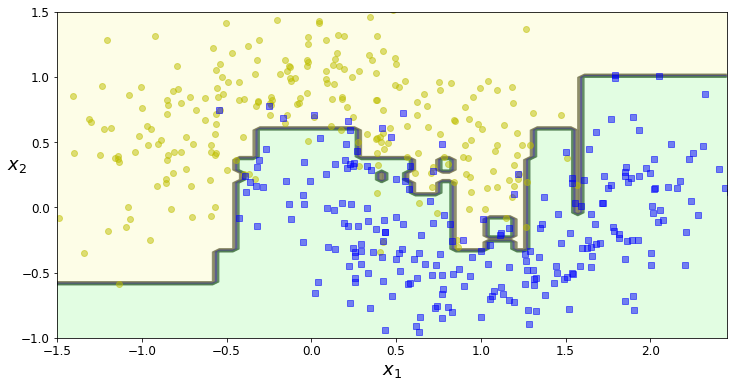

In [7]:
# Plot
plt.figure( figsize=(12,6) )
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


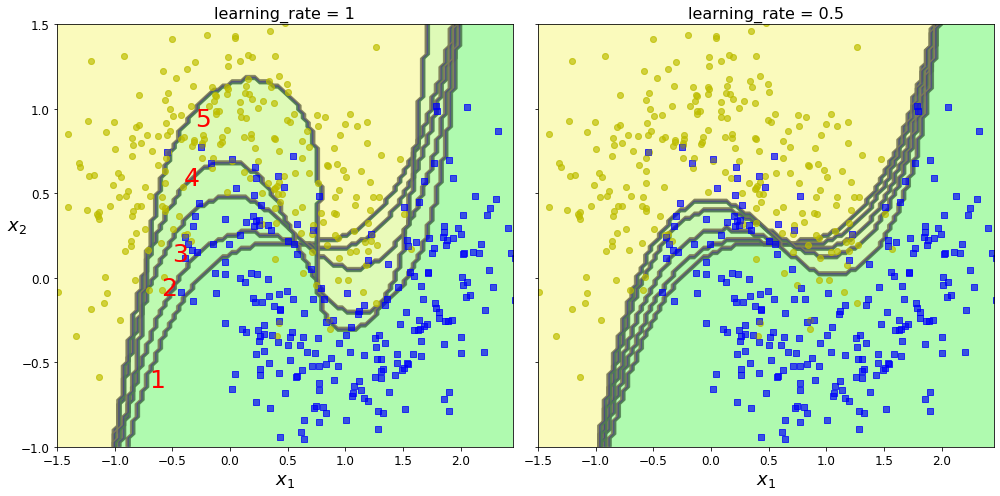

In [13]:
from sklearn.svm import SVC

m = len(X_train)

# Figure
fix, axes = plt.subplots(ncols=2, figsize=(14, 7), sharey=True)

for (subplot, learning_rate) in [(0, 1), (1, 0.5)]:
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])

    for i in range(5):
        # Model and training
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        
        # Predicting
        y_pred = svm_clf.predict(X_train)
        
        sample_weights[y_pred != y_train] *= (1. + learning_rate)
        
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=25, color='r')
        plt.text(-0.6, -0.10, "2", fontsize=25, color='r')
        plt.text(-0.5,  0.10, "3", fontsize=25, color='r')
        plt.text(-0.4,  0.55, "4", fontsize=25, color='r')
        plt.text(-0.3,  0.90, "5", fontsize=25, color='r')
    else:
        plt.ylabel("")


save_fig("boosting_plot")
plt.show()

**This figure shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel).**

**The first classifier gets many instances wrong, so their weights get boosted.**

**The second classifier therefore does a better job on these instances, and so on. (The numbers 1, 2, 3, 4, 5 show the orders of classifiers)**

**The plot on the right represents the same sequence of predictors, except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration).**

**As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.**

**^Note^: Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.**

In [10]:
# The attributes of the AdaBoost_Classifier
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

**Warning:**

**There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.**

# **Gradient Boosting**

**Another very popular boosting algorithm is Gradient Boosting. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor.**

**However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.**

**Let’s go through a simple regression example, using Decision Trees as the base predictors (of course, Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):**

In [14]:
# data
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [15]:
from sklearn.tree import DecisionTreeRegressor

# model and training
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [16]:
# residual errors
y2 = y - tree_reg1.predict(X)

# Another model and training
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [17]:
# residual errors
y3 = y2 - tree_reg2.predict(X)

# Another model and training
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

**Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:**

In [18]:
# New data for testing
X_new = np.array([[0.8]])

In [19]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [20]:
# predict
y_pred

array([0.75026781])

In [21]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


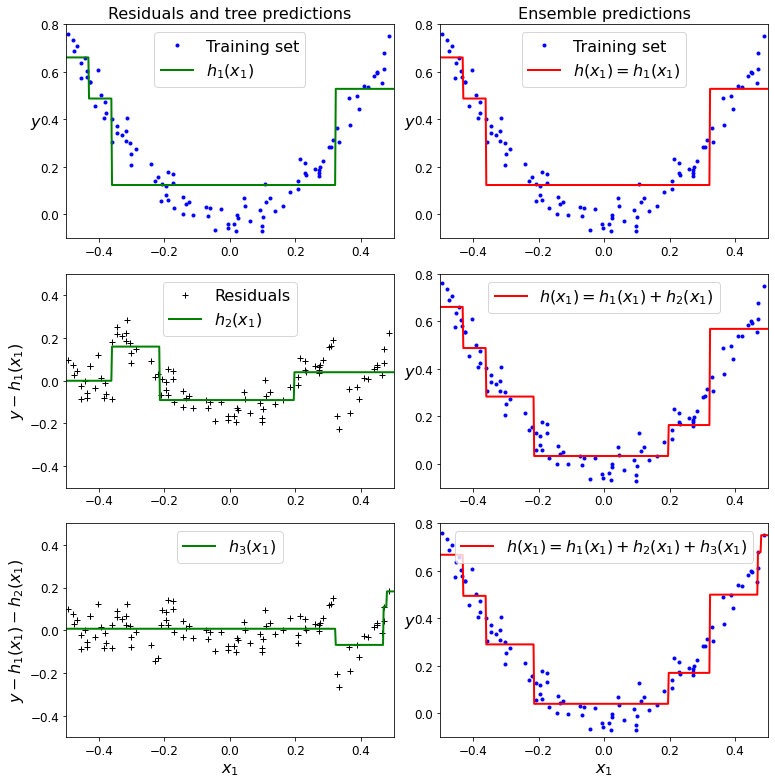

In [22]:
# Plot figures
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

**This figure represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column.**

**- In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions.**

**- In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees.**

**- Similarly, in the third row another tree is trained on the residual errors of the second tree.**

**You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.**

## **Use Scikit-Learn’s GradientBoostingRegressor class**

**A simpler way to train Gradient Boosted Regression Trees (GBRT) ensembles is to use Scikit-Learn’s GradientBoostingRegressor class. Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., max_depth, min_samples_leaf), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators). The following code creates the same ensemble as the previous one:**

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

# GradientBoostingRegressor with learning_rate=1.0
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
# GradientBoostingRegressor with learning_rate=0.1
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


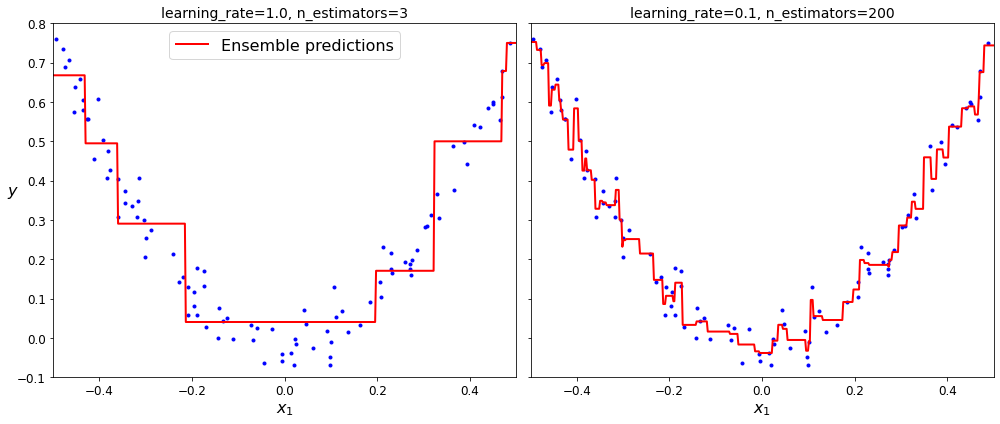

In [26]:
# Figures
fix, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# for GradientBoostingRegressor with learning_rate=1.0
plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# For GradientBoostingRegressor with learning_rate=0.1
plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better.**

**This is a regularization technique called shrinkage. Figure above shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.**

**In order to find the optimal number of trees, you can use early stopping.**

A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.).

The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

## Gradient Boosting with Early stopping

In [27]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error

# data: training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# The model and training
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# The error at each stage, find the best number of trees
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

# the best number of trees for the model
bst_n_estimators = np.argmin(errors) + 1

# train again with the optimal number of trees
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
# Find the minimum error
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


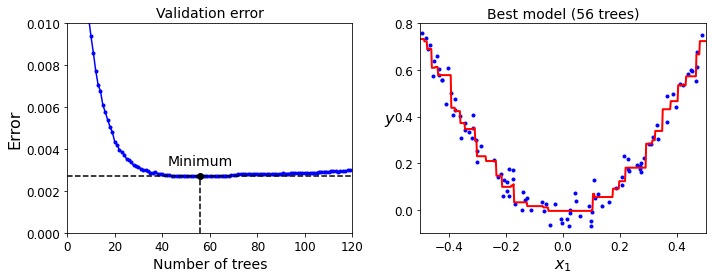

In [29]:
# Plot figures
plt.figure(figsize=(10, 4))

# For the validation error
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

# For the best model
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

**It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number).**

**You can do so by setting *warm_start=True*, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:**

In [30]:
# GradientBoostingRegressor with early stopping by actually stopping training early.
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error  = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    # Training
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)

    # Predict
    y_pred    = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if (val_error < min_val_error):
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

**The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree.**

**For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this technique trades a higher bias for a lower variance. It also speeds up training considerably. This is called Stochastic Gradient Boosting.**

In [31]:
# The optimal number of estimators / optimal number of trees
print('The optimal number of estimators: ', gbrt.n_estimators)

The optimal number of estimators:  61


In [32]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**Note:** It is possible to use Gradient Boosting with other cost functions. This is controlled by the loss hyperparameter (see Scikit-Learn’s documentation for more details).

## Using XGBoost

It is worth noting that an optimized implementation of Gradient Boosting is available in the popular Python library XGBoost, which stands for Extreme Gradient Boosting. This package was initially developed by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC), and it aims to be extremely fast, scalable, and portable. In fact, XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [33]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [34]:
if xgboost is not None: 
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[10:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


**XGBoost also offers several nice features, such as automatically taking care of early stopping:**

In [37]:
if xgboost is not None:
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=2
              )
    
    y_pred = xgb_reg.predict(X_val)
    
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)


# If early stopping occurs, the model will have three additional fields: clf.best_score, clf.best_iteration and clf.best_ntree_limit.
print( 'xgb_reg.best_score', xgb_reg.best_score )
print( 'xgb_reg.best_iteration', xgb_reg.best_iteration )
print( 'xgb_reg.best_ntree_limit', xgb_reg.best_ntree_limit)

[11:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [38]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [39]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 3: 21.4 ms per loop


## **Stacking Ensemble**

**Stacking (short for stacked generalization). It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?**

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.datasets        import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [45]:
from sklearn.ensemble       import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm            import LinearSVC
from sklearn.neural_network import MLPClassifier # 'multi-layer perceptron (MLP)'

In [46]:
# 4 classifiers
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf   = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf           = LinearSVC(random_state=42)
mlp_clf           = MLPClassifier(random_state=42)

In [47]:
# Training the 4 models
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [58]:
estimator_names = ['random_forest', 'extra_trees', 'SVM', 'multi-layer perceptron (MLP)']

# Get score of each classifier
print( estimator_names )
[estimator.score(X_val, y_val) for estimator in estimators]

['random_forest', 'extra_trees', 'SVM', 'multi-layer perceptron (MLP)']


[0.9692, 0.9715, 0.8397, 0.9639]

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [49]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [50]:
X_val_predictions

array([[5., 5., 8., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

**Stacking**

**Each of the predictors predicts a different value, and then the final predictor (called a blender, or a meta learner) takes these predictions as inputs and makes the final prediction**

In [59]:
# RandomForestClassifier as the final predictor (or a blender)
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [60]:
# The score
rnd_forest_blender.oob_score_

0.9704

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

**Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_**

In [53]:
# Evaluate the ensemble on the test set
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [61]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [62]:
# from sklearn.metrics import accuracy_score
# The score
accuracy_score(y_test, y_pred)

0.9655

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.